# Why was it so difficult to come up with an algorithm that worked?
Going left to right:
- the minimum takes values from other regimes
- thresholds for key-accesses-within-window or key-evictions 

The new algorithm goes right to left:
- tracks the minimum value we have seen thus far for each point
- for points z, y, x, if the min is the same, we are in a regime
  - although the min might not have shown up in y, we had seen it in z, so for y we know we are in z's fan
  - this is **most likely** to work because accesses to the bottom of the fans are more dense
- *key insight*: we cluster based on minimum value, which can only be achieved by going right to left

In [1]:
%matplotlib inline
from helpers import *
import time
props = dict(facecolor='black', width=1, headwidth=10)    


In [2]:
dfs = {} # global data structure with parsed data
parse(dfs, "4 Node, 100K", "../results/scale-workers-4-71541")
parse(dfs, "4 Node, 1M",   "../results/scale-workers-1M-4-71537")
df = clean_df(dfs, ("4 Node, 1M", "DBMemoryGet", "4"))

... parsed: scale-workers-4-71541 ... parsed: scale-workers-1M-4-71537


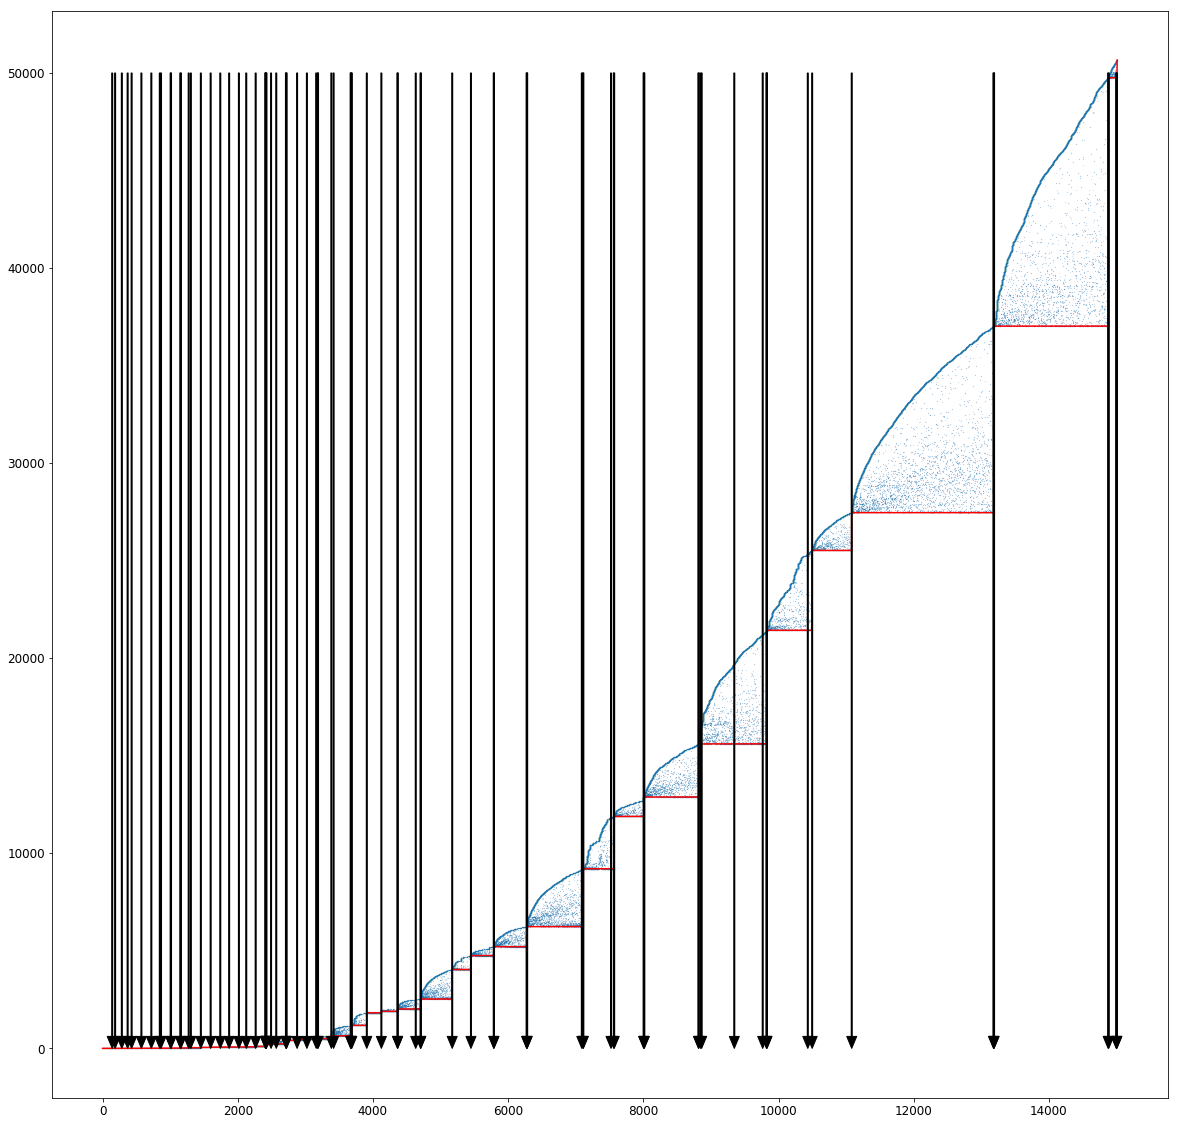

In [3]:
def find_regimes(df, window=120, ymax=50000):
    #d = df[df['shift'] > 8000]
    #d = df[df['shift'] < 10000]  
    d = df
    x = d['shift'].astype(int)
    y = d['id'].astype(int)
    X = np.matrix(zip(x,y))
    X = np.squeeze(np.asarray(X))        # matrix of [shift, id] pairs
    lowestAfter = [0]*len(X)             # get lowest value after each index (list of [value, index])
    seen = X[-1][1]                      # value, index
    regimes = []
    for i in range(len(X)-1, -1, -1):    # build oracle array, that tells you when lowest value expires
        if X[i][1] < seen:               # if the next value is smaller than anything I have seen
            seen = X[i][1]               # save the current lowest keyID
            regimes.append((X[i][0], seen))
        lowestAfter[i] = (X[i][0], seen) # for this index, save the lowest seen value

    fig, ax = plt.subplots(1, 1, figsize=(20,20))
    ax.scatter(x, y, s=0.005)
    ax.plot([a[0] for a in lowestAfter], [a[1] for a in lowestAfter], label="oracle", color='red')
    lastr = regimes[0][0]
    for r in regimes:
        if lastr - r[0] > window:
            ax.annotate("", xy=(r[0], 0), xytext=(r[0], ymax), arrowprops=props, ha="center")
            lastr = r[0]
            
df = clean_df(dfs, ("4 Node, 1M", "DBMemoryGet", "4"))            
find_regimes(df, window=1)


#df = clean_df(dfs, ("4 Node, 100K", "DBMemoryGet", "4"))
#find_regimes(df, window=240, ymax=160000)

# Why do we have those double bars and bars in the wrong place?
- lowest key of keyspace accesses sometimes ends, in which case we aggressively think there is a regime change

Solution:
- check the size of the keyspace at each timestep; if the key is within the regime we already started, then we are still in the regime

In [4]:
def find_regimes(df, window=120, ymax=50000):
    x = df['shift'].astype(int)
    y = df['id'].astype(int)
    X = np.matrix(zip(x,y))
    X = np.squeeze(np.asarray(X))        # matrix of [shift, id] pairs
    lowestAfter = [0]*len(X)             # get lowest value after each index (list of [value, index])
    smallest = X[-1][1]                  # value, index
    regimes = []

    accessesPerTS = {}
    accesses = []
    ts = X[-1][0]
    for i in range(len(X)-1, -1, -1):    # build oracle array, that tells you when lowest value expires
        if X[i][1] < smallest:           # if the next value is smaller than anything I have seen
            smallest = X[i][1]           # save the current lowest keyID
            regimes.append((X[i][0], smallest))
        lowestAfter[i] = (X[i][0], smallest) # for this index, save the lowest seen value
        
        if ts != X[i][0]:
            ts = X[i][0]
            accessesPerTS[ts] = accesses
            accesses = []
            
        accesses.append(X[i][1])
    
    # find the range of each regime
    start = 0
    ranges = []
    for i in range(len(regimes)-1, -1, -1):
        end = regimes[i][0]
        minkey = regimes[i][1]
        if start != end:
            end -= 1
            maxkey = 0
            for ts in range(start, end):
                if ts in accessesPerTS:
                    for key in accessesPerTS[ts]:
                        if key > maxkey:
                             maxkey = key
            if maxkey != 0:
                ranges.append(((start, end), (minkey, maxkey))) # range: (start, end), (minkey, maxkey)
                    #print "appending (" + str(start) + "," + str(end)+ ","+str(minkey)+ "," + str(maxkey) + ")"
            
        start = regimes[i][0]
    
    pruned_ranges = []
    start = ranges[0][0][0]
    for i in range(0, len(ranges)-1):
        if ranges[i+1]:
            maxkey = ranges[i][1][1]
            next_maxkey = ranges[i+1][1][1]
            next_minkey = ranges[i+1][1][0]
            if maxkey < next_minkey: # and maxkey > minkey:
                r = ranges[i]
                pruned_ranges.append(((start, r[0][1]), (r[1][0], r[1][1])))
                start = r[0][1]
            #else:
                #print "pruning: " + str(ranges[i])
                #start = ranges[i][0][0]
        else:
            pruned_ranges.append(ranges[i])
    
    #print ranges[:10]
    #for r in pruned_ranges: print r
    # find the max value in each regime    

    #fig, ax = plt.subplots(1, 1, figsize=(20,4))
    #ax.scatter(x, y, s=0.005)
    #ax.plot([a[0] for a in lowestAfter], [a[1] for a in lowestAfter], label="oracle", color='red')
    #ax.set_xlim(8000, 10000)
    #ax.set_ylim(10000, 25000)
    
    #lastr = pruned_ranges[0][0]
    #for r in pruned_ranges:
        #ax.annotate("", xy=(r[0][0], 0), xytext=(r[0][0], 50000), arrowprops=props, ha="center")
    print pruned_ranges
        
            
df = clean_df(dfs, ("4 Node, 1M", "DBMemoryGet", "4"))            
find_regimes(df, window=0)#, ymax=20000)


#df = clean_df(dfs, ("4 Node, 100K", "DBMemoryGet", "4"))
#find_regimes(df, window=240, ymax=160000)

[((0, 142), (1, 1)), ((142, 185), (2, 2)), ((185, 284), (3, 3)), ((284, 370), (4, 4)), ((370, 429), (5, 5)), ((429, 574), (6, 6)), ((574, 721), (8, 8)), ((721, 864), (10, 10)), ((864, 1011), (13, 13)), ((1011, 1157), (18, 18)), ((1157, 1305), (25, 27)), ((1305, 1453), (36, 48)), ((1453, 1597), (51, 60)), ((1597, 1741), (63, 63)), ((1741, 1871), (68, 70)), ((1871, 2016), (72, 75)), ((2016, 2125), (76, 81)), ((2125, 2263), (83, 100)), ((2263, 2409), (102, 149)), ((2409, 2569), (217, 217)), ((2569, 2717), (234, 235)), ((2717, 2720), (292, 413)), ((2720, 2876), (415, 452)), ((2876, 3021), (456, 463)), ((3021, 3186), (467, 467)), ((3186, 3383), (500, 639)), ((3383, 3686), (677, 1181)), ((3686, 3907), (1182, 1823)), ((3907, 4123), (1825, 1900)), ((4123, 4363), (1902, 2017)), ((4363, 4705), (2022, 2528)), ((4705, 5172), (2530, 4042)), ((5172, 5448), (4044, 4754)), ((5448, 5789), (4760, 4789)), ((5789, 6281), (5233, 6239)), ((6281, 7111), (6251, 9206)), ((7111, 7567), (9211, 11887)), ((7567, 8

CPU times: user 350 ms, sys: 20 ms, total: 370 ms
Wall time: 351 ms
CPU times: user 310 ms, sys: 20 ms, total: 330 ms
Wall time: 306 ms


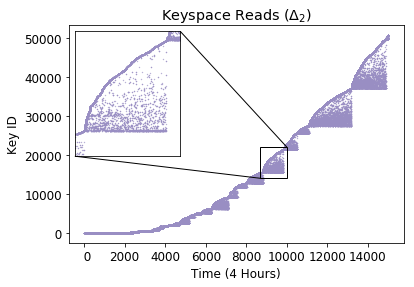

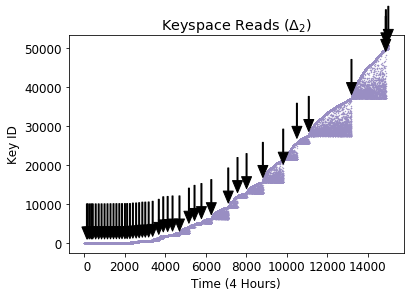

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def find_regimes(ax, df, window=5, ymax=50000, draw_regimes=True):
    x = df['shift'].astype(int)          # parse input into matrix of [time, id] access pairs
    y = df['id'].astype(int)
    data = np.squeeze(np.asarray(np.matrix(zip(x,y))))
    
    # index by timestep, ts -> [accesses]; this algorithm assumes we tss increasing
    accesses = [] # in this timestamp
    current_ts = data[-1][0] 
    lowest = data[-1][1]
    regimes = []
    end = data[-1][0]
    largest = 0
    for i in range(len(data)-1, -1, -1):
        ts, ID = data[i]
        if ts != current_ts:
            if ID < lowest:
                regimes.append(((ts, end), (lowest, largest)))# np.max(accesses))))
                lowest = ID                                                
                end = ts
                accesses = []
                largest = 0
            current_ts = ts
        #accesses.append(ID)
        if ID > largest: largest = ID
    regimes.append(((0, end), (ID, largest)))

    regimes = [regimes[i] for i in range(len(regimes)-1, -1, -1)]
    filtered = []
    start = regimes[0][0][0]
    for i in range(0, len(regimes)-1):
        if regimes[i+1]:
            minkey = regimes[i][1][0]
            maxkey = regimes[i][1][1]
            next_maxkey = regimes[i+1][1][1]
            next_minkey = regimes[i+1][1][0]
            if maxkey < next_minkey:
                r = regimes[i]
                filtered.append(((start, r[0][1]), (r[1][0], r[1][1])))
                start = r[0][1]
        else:
            filtered.append(regimes[i]) 

    ax.set_title(r'Keyspace Reads ($\Delta_2$)')
    ax.set_ylabel("Key ID")
    ax.set_xlabel("Time (4 Hours)")   
    ax.scatter(x, y, s=0.1, color='#998ec3')
    labels = ['{:3.0f}'.format(x) for x in ax.get_yticks()]
    labels[0] = ""
    ax.set_yticklabels(labels)    
    labels = ['{:3.0f}'.format(x) for x in ax.get_xticks()]
    labels[0] = ""
    ax.set_xticklabels(labels)        
    if draw_regimes:
        props = dict(facecolor='black', width=1, headwidth=10)    
        rlast = filtered[0]
        for r in filtered:
            if r[0][0] - rlast[0][0] > window:
                ax.annotate("", xy=(r[0][0], r[1][0]+1000), xytext=(r[0][0], r[1][0]+10000), arrowprops=props, ha="center")
                rlast = r
    #|print filtered

df = clean_df(dfs, ("4 Node, 1M", "DBMemoryGet", "4"))
fig, ax = plt.subplots(1, 1)
%time find_regimes(ax, df, draw_regimes=False)
fig.savefig("keyspace.png", bbox_inches='tight', dpi=400)

axins = zoomed_inset_axes(ax,4,loc=2)
find_regimes(axins, df, draw_regimes=False)
axins.set_xlim(8700, 10000)
axins.set_ylim(14000, 22000)
mark_inset(ax, axins, loc1=3, loc2=1)#, color="white", ec="0")
axins.set_xlabel(""); axins.set_xticks([]); axins.set_ylabel(""); axins.set_yticks([]); axins.set_title("")

##axins.patch.set_alpha(0.7)
#ax.patch.set_alpha(0.7)
#ax.set_axis_bgcolor("white")
#axins.set_axis_bgcolor("white")

#axins = zoomed_inset_axes(ax,15,loc=4)
#find_regimes(axins, df, draw_regimes=False)
#axins.set_xlim(3350, 3700)
##axins.set_ylim(500, 1300)
#mark_inset(ax, axins, loc1=3, loc2=2, color="green", ec="0")
#axins.set_xlabel(""); axins.set_xticks([]); axins.set_ylabel(""); axins.set_yticks([]); axins.set_title("")
fig.savefig("keyspace-zoomed.png", bbox_inches='tight', dpi=400)

fig, ax = plt.subplots(1, 1)
%time find_regimes(ax, df)
fig.savefig("keyspace-regimes.png", bbox_inches='tight', dpi=400)
    
#df = clean_df(dfs, ("4 Node, 100K", "DBMemoryGet", "4"))
#%time find_regimes(ax[1], df, ymax=160000, window=60)
fig.savefig("../../../paper/figures/keyspace-analysis_locality.png", bbox_inches='tight', dpi=400)

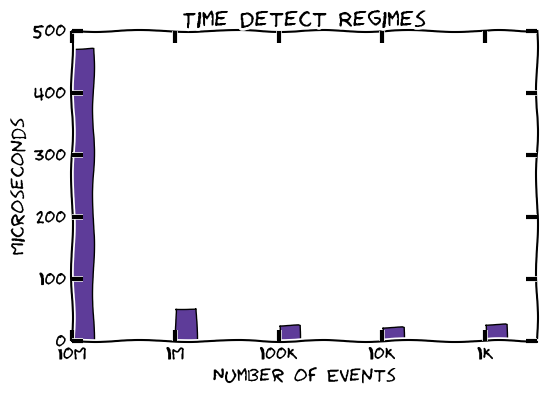

In [6]:
fig, ax = plt.subplots(1, 1)
fxn = [473, 54, 27, 24, 28]
labels = ["10M", "1M", "100K", "10K", "1K"]
x = np.arange(len(fxn))
ax.bar(x, fxn, width=0.2, label="Get", color='#5e3c99')
ax.set_xticks(range(0, len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Microseconds")
ax.set_title("Time Detect Regimes")
ax.set_xlabel("Number of Events")
fig.savefig("detection-time.png", bbox_inches='tight', dpi=400)


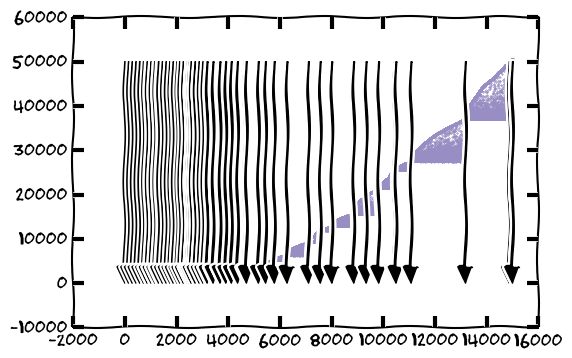

In [7]:
xlim=()
#ylim=()

fig, ax = plt.subplots(1, 1)
x = df['shift'].astype(int)
y = df['id'].astype(int)
ax.scatter(x, y, s=0.1, color='#998ec3')
x = [0, 143, 285, 430, 575, 722, 847, 865, 1007, 1012, 1013, 1151, 1158, 1159, 1274, 1306, 1454, 1598, 1599, 1742, 1872, 1873, 2017, 2126, 2264, 2265, 2410, 2411, 2412, 2414, 2421, 2423, 2493, 2570, 2713, 2718, 2719, 2721, 2877, 2878, 3022, 3023, 3161, 3185, 3187, 3188, 3384, 3385, 3418, 3671, 3674, 3680, 3687, 3908, 3909, 4124, 4125, 4364, 4365, 4366, 4633, 4706, 4707, 4708, 5173, 5449, 5450, 5788, 5790, 6274, 6278, 6282, 7090, 7107, 7112, 7113, 7522, 7563, 7568, 7569, 8005, 8009, 8015, 8817, 8818, 8819, 8847, 8863, 9346, 9766, 9822, 9823, 9826, 9828, 9829, 10433, 10498, 11082, 11083, 13180, 13187, 13189, 14877, 14884, 14885, 14996, 15003, 15006, 15008]#ax.scatter(x, np.ones(len(x)))
for r in x:
    ax.annotate("", xy=(r, 0), xytext=(r, 50000), arrowprops=props, ha="center")

